# Importing libraries

In [1]:
import os
import json
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
from sklearn.metrics import recall_score

from utils.inference import *
from utils.metrics import *

import warnings
warnings.filterwarnings("ignore")

%config Completer.use_jedi = False

# Specifying trained model

In [2]:
EXP_NAME = '1b5fabcd-9b11-4188-b193-1e0c052ba0f4'

with open(f'experiments/{EXP_NAME}/config.json') as json_file:
    config = json.load(json_file)

config = edict(config)

# Validating

In [3]:
df = pd.DataFrame(columns=['contrast', 'recall', 'top_10_crop'])

for subject in tqdm(config.subjects):
    
    with open(f'experiments/{EXP_NAME}/predictions/{subject}.json') as json_file:
        net_output = json.load(json_file)
    
    predictions_inside_brain = np.array(net_output['predictions']) * (1 - np.array(net_output['air_maks']))
    labels_inside_brain = np.array(net_output['labels']) * (1 - np.array(net_output['air_maks']))

    contrast = np.round(calculate_contrast(labels_inside_brain, predictions_inside_brain), decimals=2)
    recall = np.round(recall_score(labels_inside_brain, (predictions_inside_brain > 0.5).astype(np.int)), decimals=2)
    top10_score = np.round(top10_f(predictions_inside_brain, labels_inside_brain, np.array(net_output['coordinates'])), decimals=2)
    
    df.loc[subject] = [contrast, recall, top10_score]

df.dropna(inplace=True)
original_df = df.copy()
df.loc['mean'] = df.mean()
df.loc['high_percent'] = percent_of_high_score(original_df, 0.5)
df.to_csv(f'experiments/{EXP_NAME}/metrics.csv')

100%|██████████| 81/81 [01:04<00:00,  1.26it/s]


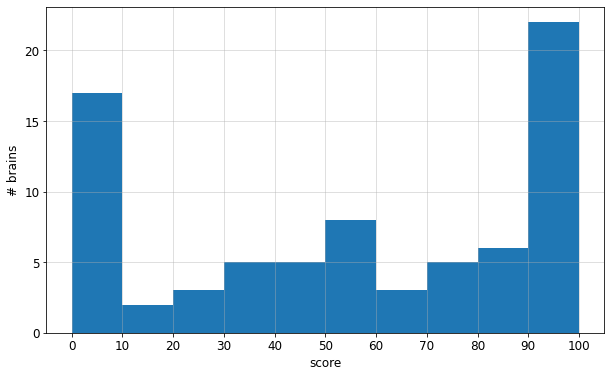

In [8]:
fig, axs =  plt.subplots(figsize=(10, 6))
plt.rcParams.update({'font.size': 12})

plt.hist(df.top_10_crop * 100, bins=10)
plt.xticks(range(0, 110, 10))
plt.ylabel('# brains')
plt.xlabel('score')
plt.grid(True, alpha=0.5)
plt.savefig(f'experiments/{EXP_NAME}/histogram_top_10_score.jpeg')
# plt.close()